In [1]:
import sys
sys.path.append('./../../designer/script/')
import os
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from design import DesignForSpecSimple
from film import FilmSimple
from spectrum import Spectrum
from utils.plot_spectrum import plot_spectrum
from utils.load_designs import load_designs_single_spec, init_film_single_spec
from utils.sort import sort_by_ith_list
import numpy as np
import copy
from utils.loss import calculate_RMS
import matplotlib.pyplot as plt

num = 500
WLS = np.linspace(400, 1200, num)
sp = np.ones(num, dtype=float)

target_spectrum_reflection = Spectrum(0., WLS, sp)

In [2]:
def load_designs_for_spec(fpath, run_num, target_spec: Spectrum, n_A, n_B, n_sub, n_inc='Air') -> list[DesignForSpecSimple]:
    inc_ang = target_spec.INC_ANG
    wls = target_spec.WLS
    
    designs = []
    for i in range(run_num):
        d_init = np.loadtxt(fpath + f'run_{i}/init') * 1000
        f_init = FilmSimple(n_A, n_B, n_sub, d_init, n_inc)
        f_init.add_spec_param(inc_ang, wls)
        f_init.calculate_spectrum()

        d_final = np.loadtxt(fpath + f'run_{i}/final') * 1000
        f = FilmSimple(n_A, n_B, n_sub, d_final, n_inc)
        f.add_spec_param(inc_ang, wls)
        f.calculate_spectrum()
        
        design = DesignForSpecSimple(target_spec, f_init, f)
        designs.append(design)
        
    return designs

fpath = './../raw_design_result/50iters_0to5mum_reflection_400-1200/'
designs_TiO2 = load_designs_for_spec(fpath, 200, target_spectrum_reflection, 'TiO2', 'SiO2', 'SiO2')

c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


c:\Users\rfeng6\.conda\envs\TFNN\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


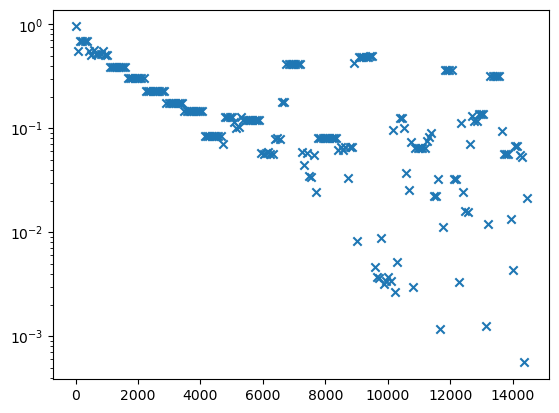

In [3]:
init_ots = []
final_ots = []
loss = []

for design in designs_TiO2:
    loss.append(design.calculate_loss())
    init_ots.append(design.get_init_ot())
    final_ots.append(design.get_current_ot())
loss = np.array(loss)


fig, ax = plt.subplots(1, 1)
ax.scatter(init_ots, loss, marker='x')

ax.set_yscale('log')

[0.00000e+00 7.06000e-01 0.00000e+00 0.00000e+00 6.40620e+01 1.41017e+02
 1.01543e+02 1.10500e+02 9.13650e+01 1.11353e+02 9.52910e+01 1.30837e+02
 6.22100e+01 7.23140e+01 2.13890e+01 1.01699e+02 8.78210e+01 1.18560e+02
 7.65630e+01 1.20990e+02 8.66300e+01 3.61800e+00 4.07610e+01 1.17685e+02
 7.63680e+01 1.23902e+02 0.00000e+00 0.00000e+00 1.15157e+02 1.20225e+02
 6.52020e+01 1.04756e+02 5.59340e+01 8.98050e+01 7.51630e+01 8.40970e+01
 7.38710e+01 8.64760e+01 2.62800e+01 7.57810e+01 5.48330e+01 7.01830e+01
 1.69610e+01 1.80000e-02 1.80000e-02 9.85800e+01 7.31530e+01 1.76190e+02
 4.85230e+01 8.07080e+01 6.60430e+01 1.01276e+02 7.65540e+01 1.00299e+02
 8.70740e+01 1.25685e+02 6.67340e+01 6.70450e+01 4.12260e+01 9.44060e+01
 4.38240e+01 4.80660e+01 6.30570e+01 1.34366e+02 1.11122e+02 1.22312e+02
 4.15110e+01 6.78290e+01 6.56220e+01 1.44796e+02 1.00211e+02 2.06738e+02
 1.21283e+02 1.76626e+02 9.07360e+01 1.36088e+02 1.63737e+02 1.27478e+02
 1.06398e+02 2.02183e+02 5.53540e+01 2.46930e+01 4.

(<Axes: title={'center': 'refractive index distribution at  801 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

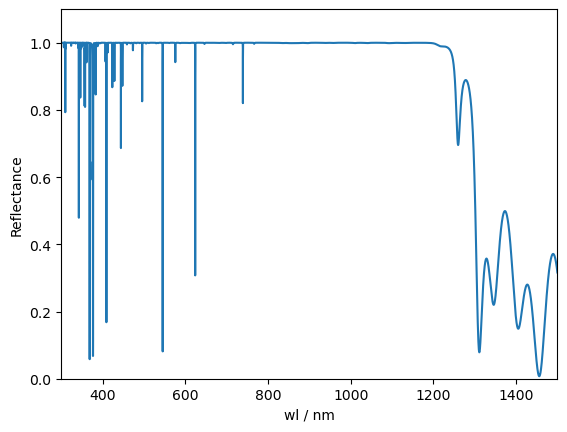

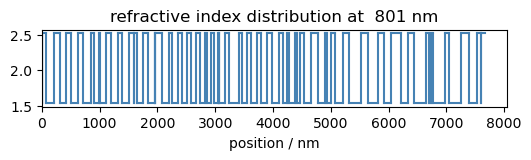

In [12]:

f = designs_TiO2[198].film
print(f.get_d())
wls_new = np.linspace(300, 1500, 10000)
f.add_spec_param(0., wls_new)
f.calculate_spectrum()
spec = f.get_spec(0., wls_new).get_R()


fig, ax = plt.subplots(1, 1)
ax.plot(wls_new, spec)
ax.set_ylabel('Reflectance')
ax.set_xlabel('wl / nm')
ax.set_ylim(0, 1.1)
ax.set_xlim(wls_new[0], wls_new[-1])


AUC = spec.mean() * (wls_new[-1] - wls_new[0])
eff = AUC / (wls_new[-1] - wls_new[0])

print(eff)


from utils.structure import plot_layer_thickness

plot_layer_thickness(f)

'''
This is a well designed film. Many other runs are trapped in local minimums.
Sharp transmission only occurs in samll wl region
Layer structure similar to that of back-reflectors, or "modulated" ones as proposed in 
    J. Krc, M. Zeman, S. L. Luxembourg, and M. Topic , "Modulated photonic-crystal structures as broadband back reflectors in thin-film solar cells", 
    Appl. Phys. Lett. 94, 153501 (2009) https://doi.org/10.1063/1.3109781
'''
